## Deep Q Learning aplicado al juego Cart Pole

In [8]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [9]:
# Cargar el entorno
env = gym.make('CartPole-v1')

# Configurar matplotlib
is_ipython = 'inline' in matplotlib.get_backend() # Verifica si el backend de matplotlib es 'inline' para mostrar los gráficos dentro del propio notebook
if is_ipython:
    from IPython import display # Permite mostrar y actualizar gráficos en línea
plt.ion() # Activa el modo interactivo de matplotlib, permitiendo actualizar los gráficos de forma dinámica sin llamar a show()

# Chequear dispisitivo a usar
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else
                      'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cpu


#### Replay Memory
Se va a utilizar una repetición de memorias para entrenar la red neuronal (DQN). Se irán almacenando las transiciones observadas por el agente, permitiendo reutilizar esos datos más tarde. A partir de un muestreo aleatorio, las transiciones de cada lote está decorrelacionadas, mejorando la estabilidad y eficiencia del modelo.

In [10]:
# Namedtuple --> Subclase de tupla que permite nombrar cada posición
# En este caso se mapean pares (estado, acción) con su resultado (proximo estado, recompensa)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Búfer cíclico que almacena las transiciones observadas recientemente
class ReplayMemory(object):

    # Crea un deque (estructura de datos que permite quitar/añadir datos desde ambos extremos) con un tamaño máximo (capacity)
    # Elimina la transición más antigua al añadir una nueva cuando se alcanza el límite de capacidad
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Guarda una transición con todos sus argumentos ('state', 'action', 'next_state', 'reward')
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Selecciona un batch aleatorio de transiciones para entrenamiento
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # Devuelve el tamaño de la memoria (cantidad de transiciones)
    def __len__(self):
        return len(self.memory)

#### Q-network
El modelo sera una red neuronal feed-forward (avance directo) que recibe la diferencia entre el parche visual de la pantalla actual y el de la anterior. Devuelve dos outputs ``Q(s, left)`` y ``Q(s, right)``, siendo ``s`` el input a la red. Lo que trata de predecir es el resultado de elegir cada opción (izq o dcha) según el input (s) que recibe.

In [11]:
class DQN(nn.Module):

    # Constructor. El modelo recibe una serie de observaciones y devuelve una serie de acciones
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__() # Llamada a la clase base nn.Module (necesario en PyTorch)
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Llama al modelo con un elemento o un batch para determinar la siguiente acción
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Entrenamiento
Se instancian el modelo y su optimizador, definiendo también algunas utilidades. La función ``select_action`` elige una acción de acuerdo a una política Epsilon-Greedy: balancea **exploración** (probabilidad *epsilon*) eligiendo una acción aleatoria y **explotación** (probabilidad *1 - epsilon*) eligiendo la mejor acción conocida hasta el momento.  
En resumen, en algunas ocasiones se utilizará el modelo para elegir una acción, y en otras se seleccionará una al azar. La probabilidad de elegir una acción aleatoria comienza en ``EPS_START`` y va decayendo exponencialmente hacia ``EPS_END``.  

La función ``plot_durations`` grafica la duración de los episodios junto con un promedio de los 100 últimos. Cada episodio es una instancia en la que el agente interactúa con el entorno, desde el estado inicial hasta un estado final. En el juego del Cart Pole, el episodio termina cuando el palo cae.

Respecto a ``γ (gamma)``, un valor más cercano a 1 significa que el agente da la misma importancia a las recompensas futuras que a las inmediatas. Cuanto más bajo sea gamma, menos peso se da a las recompensas futuras y más a las inmediatas.  

En cuanto a ``τ (tau)``, controla la tasa de actualización de la red objetivo. En algoritmos como DQN se suelen utilizar dos redes neuronales: la de **red de evaluación**, aquella que se entrena y toma decisiones, y la **red objetivo**, una copia que se actualiza con menos frecuencia y se utiliza para calcular las recompensas objetivo de forma más estable.
Existen dos formas de actualizar la red objetivo:  
*Actualización completa y poco frecuente* --> Cada ciertos pasos copia los pesos de la red de evaluación.  
*Actualización suave (TAU)* --> Después de cada paso interpola sus pesos actuales y los de la red de evaluación. Con TAU más cerca de 1 el cambio es casi inmediato, y cuanto más cerca de 0 más lento es el cambio, siendo más estable.


In [12]:
BATCH_SIZE = 128 # Número de transiciones muestreadas desde el búfer de repetición
GAMMA = 0.99 # Factor de descuento (entre 0 y 1)
EPS_START = 0.9 # Valor inicial de epsilon (probabilidad de elegir una acción aleatoria)
EPS_END = 0.05 # Valor final de epsilon
EPS_DECAY = 1000 # Contorla el descenso exponencial de epsilon. Más alto significa un descenso más lento.
TAU = 0.005 # Tasa de actualización de la red objetivo
LR = 1e-4 # Tasa de aprendizaje del optimizador AdamW

# Obtener el número de acciones posibles para el entorno creado
n_actions = env.action_space.n
print(f'Acciones posibles: {n_actions} (izquierda y derecha)')

# Obtener el número de observaciones de estado (cantidad de parámetros que describen el estado actual --> posiciones, velocidades, ángulos...)
state, info = env.reset()
n_observations = len(state)
print(f'Observaciones de cada estado: {n_observations}')

# Instanciar la red de evaluación (policy) y la red objetivo (target)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copia los pesos de la red principal en la red objetivo

# Cargar el optimizador y la memoria de transiciones que se va a utilizar
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # Habilita la variante AMSGrad para problemas de convergencia
memory = ReplayMemory(10000)

# Inicializar los pasos
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random() # Número aleatorio entre 0 y 1

    # Determina la probabilidad de elegir entre exploración o explotación
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY) # math --> e elevado a -(steps_done/EPS_DECAY)

    steps_done += 1

    # Si sample es mayor que eps_threshold, el agente explota (mejor acción aprendida)
    if sample > eps_threshold:
        with torch.no_grad(): # Desactiva el cálculo de gradientes, solo se necesita que el modelo tome una decisión
            # Evalúa para el estado actual
            # Devuelve el índice de la acción con el mayor valor Q
            # Reestructura el tensor a 2 dimensiones (1 fila, 1 columna)
            return policy_net(state).max(1).indices.view(1, 1)
        
    # Si sample es igual o menor al threshold, el agente explora (acción aleatoria)
    else:
        # Genera una acción aleatoria dentro del espacio de acciones del entorno (env)
        # Almacena el tensor en el dispositivo
        # Define el tipo de datos como long (adecuado para índices de acciones)
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# Lista para guardar la duración de cada episodio (medida en número de acciones)
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float) # Crea un tensor de tipo float siguiendo la lista previa
    if show_result:
        plt.title('Result')
    else:
        plt.clf() # Limpia el contenido actual de la figura
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy()) # Grafica el tensor en forma de array de NumPy (requisito)

    # Tomar las medias de 100 episodios y también graficarlas
    if len(durations_t) >= 100:
        # Crea ventanas de tamaño 100 avanzando de 1 en 1. Ej len(durations_t) = 102 --> [[1, 2, 3...100], [2, 3, 4...101], [3, 4, 5...102]]; 3 ventanas
        # Calcula la media para cada ventana
        # Aplana el tensor resultante a una sola dimensión
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)

        # Crea un tensor de ceros de tamaño 99
        # Concatena el tensor means: [0, 0, 0, 0..., 50.5, 51, 54.3, ...]
        # Al calcular los promedios a partir de 100 episodios, es necesario generar las de los primeros 99
        # para que los índices vayan alineados con los episodios originales
        # Del 1 al 99 --> 0; A partir del 100 --> means
        means = torch.cat((torch.zeros(99), means))

        plt.plot(means.numpy())

    plt.pause(0.001) # Pausa un instante para actualizar los gráficos

    # Verifica si estamos en un entorno Python (hecho previamente)
    if is_ipython:
        # Modo entrenamiento
        if not show_result:
            display.display(plt.gcf()) # Obtiene la figura actual y la muestra en la celda
            display.clear_output(wait=True) # Limpia la salida anterior, dejando espacio para la siguiente
        else:
            display.display(plt.gcf())

Acciones posibles: 2 (izquierda y derecha)
Observaciones de cada estado: 4


#### Bucle de entrenamiento
La función ``optimize_model`` primero toma una muestra de un batch, concatena todos los tensores en uno más grande, calcula ``Q`` usando la **red policy** y ``V`` (función de valor - esperado de recompensa futura) usando la **red target** y los combina en la función de pérdida.  
En resumen, el proceso es el siguiente:  
  - La red principal (policy) toma el estado actual ``s`` y predice ``Q(s, a)`` para cada posible acción.
  - Tras realizar una acción ``a`` y recibir una recompensa ``r``, llega a un nuevo estado ``s'``.
  - La red objetivo (target) calcula el valor máximo entre todas las posibles acciones para ``s'``: ``max Qtarget(s', a)``.
  - La red objetivo calcula el **valor objetivo** para ``s`` utilizando el nuevo estado ``s'``: ``target = r + γ * max Qtarget(s', a)``.
  - La red principal ajusta sus predicciones para ``s`` (estado anterior) mediante la **función de pérdida**: diferencia entre ``Q(s, a)`` y el **valor objetivo**.
  - Se repite el proceso hasta el final del episodio.
La **red objetivo** se usa únicamente para calcular el valor objetivo de ``s`` usando el valor máximo en el estado ``s'``. Se actualiza suavemente utilizando ``τ (TAU)`` o cada ciertos paso, en línea con la red principal. Esto da estabilidad al entrenamiento y evita grandes oscilaciones en el aprendizaje.

**Nota**: Antes de empezar el entrenamiento el agente ha interactuado con el entorno, generando con cada interacción una ``transición (state, action, next_state, reward)``. Estas transiciones se van guardando en la ``memory`` y son luego utilizadas para el entrenamiento en batches.

In [13]:
def optimize_model():
    # Comprueba que al menos se puede obtener un lote de la memoria
    if len(memory) < BATCH_SIZE:
        return
    
    # Obtiene una muestra del tamaño fijado para los lotes
    transitions = memory.sample(BATCH_SIZE)

    # Convierte la muestra obtenida en una muestra de transiciones (state, action, next_state, reward)
    # Se almacenan de forma que batch.state contiene todos los estados, batch.action todas las acciones, etc.
    batch = Transition(*zip(*transitions))

    # Verifica si cada next_state es diferente de None, devolviendo un tensor con valores True y False
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    
    # Crea un tensor y agrupa todos los next_state que no son None (no son estados finales)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Concatena los tensores de estados, acciones y recompensas para crear lotes y poder procesar varios en paralelo
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Pasa el lote de estados a la red principal, que calcula Q para todas las acciones posibles (tensor imaginario Q_values: [[1.2, 0.5], [0.8, -1.0], [2.0, 1.3], etc...)
    # Gather recoge los valores Q para las acciones que realmente se tomaron durante las transiciones (action_batch: [[0], [0], [1], [0], [1], etc...])
    # Se pone 1 porque action_batch es un tensor 2d donde las acciones se guardan en la segunda dimensión
    # Al final se obtiene un tensor con el valor Q para cada acción tomada (state_action_values: [[1.2], [0.8], [1.3], etc...])
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Crea un tensor de ceros del tamaño del batch para ir calculando V = max Qtarget(s', a)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Solo se calcula V para los estados que no son finales, el resto quedan como 0
    # Se utiliza la red objetivo para calcular V en los estados que no son finales (si es final ya no hay next_state, claro)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Calcula el valor objetivo (target = r + gamma * max Qtarget(s', a))
    expected_state_action_values = reward_batch + GAMMA * next_state_values

    # Instanciar la función de pérdida (Huber Loss) que mide la diferencia entre dos tensores
    # En errores pequeños la pérdida es cuadrática (MSE) y en errores grandes es lineal
    # Se utiliza unsqueeze para añadir una dimensión extra y que ambos tensores coincidan: (batch_size, 1)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimiza la red principal (optimizer asociado a policy_net) reseteando a cero los gradientes y los calcula de nuevo usando backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Aplica "clipping de gradientes" a los parámetros de la red, limitando sus valores absolutos a un máximo de 100
    # Si el gradiente es menor que 100 se queda como está, y si es mayor se cambia a 100
    # Después actualiza los parámetros
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Comenzar a entrenar
Se resetea el entorno para obtener el ``estado`` inicial (en teoría con el palo en vertical). Después se ejecuta una ``acción`` y se observa el ``siguiente estado`` y la ``recompensa``. La recompensa está fijada **siempre** como **1**, independientemente de la acción (el objetivo es que el agente maximice la duración del episodio, por cada movimiento que aguanta con el palo sin caerse suma 1 punto).
Después del primer paso se **optimiza** el modelo. Cuando termina el episodio (el palo cae) se reinicia el loop.

Complete


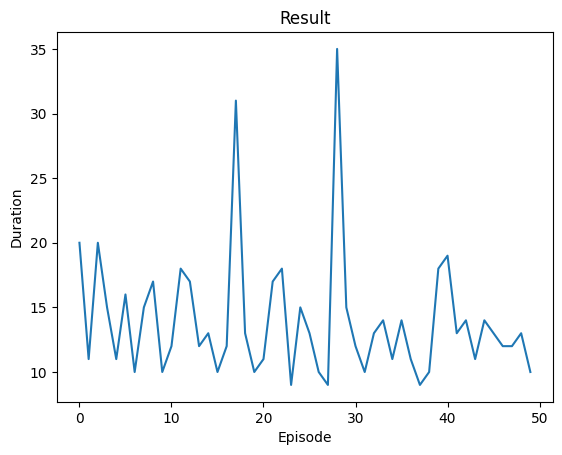

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Fija 600 episodios si hay una GPU disponible, si no lo deja en 50
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Inicializar el entorno y obtener el estado inicial
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # Añade una dimensión en el eje 0: (state,) --> (1, state)

    for t in count(): # Crea un bucle infinito
        action = select_action(state) # Elegir una acción para el estado actual

        # Ejecuta la acción y devuelve esas variables
        # Terminated (bool) indica si el episodio ha llegado a un estado terminal (se cayó el palo)
        # Truncated (bool) indica si el episodio se ha interrumpido sin llegar al estado final (alcanza el límite de pasos sin tirar el palo)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward = torch.tensor([reward], device=device) # Crea un tensor con las recompensas y lo pasa al dispositivo
        done = terminated or truncated # Marcador de si ha terminado el episodio con este paso

        # Si no ha terminado (por fallo) se carga el next_state según las observaciones
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Almacenar toda esta transición en la memoria, avanzar al siguiente estado y optimizar la red policy
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        # Actualización suave de la red target
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU) # Aplica la fórmula: θ′ = θ * τ + θ′ * (1 − τ)
        
        # Chequea si acabó el episodio
        # Si es así, añade la duración a la lista de duraciones y grafica
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True) # Maca True para que pinte 'Result' en vez de 'Training'
plt.ioff() # Desactiva las gráficas interactivas, teniendo que llamar a show() para pintar
plt.show()